In [6]:
import os
import pandas as pd
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
os.makedirs("data/data_raw/disaster_images", exist_ok=True)

colors = ["red", "green", "blue", "yellow", "purple"]
captions = [
    "A wildfire burns through the forest.",
    "A flooded street after the hurricane.",
    "Snow covers the rooftops after a storm.",
    "Collapsed buildings from an earthquake.",
    "Smoke fills the air in downtown."
]

image_paths = []
for i, color in enumerate(colors):
    img = Image.new("RGB", (256, 256), color=color)
    path = f"data/data_raw/disaster_images/img_{i}.jpg"
    img.save(path)
    image_paths.append(path)

df_mock = pd.DataFrame({"image_path": image_paths, "caption": captions})
df_mock.to_csv("data/data_raw/image_caption_pairs.csv", index=False)
print(" Mock image-caption data created.")


 Mock image-caption data created.


In [8]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [9]:
def compute_clip_score(image_path, text):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = clip_processor(text=[text], images=image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            score = logits_per_image.softmax(dim=1)[0][0].item()
        return score
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [10]:
image_df = pd.read_csv("data/data_raw/image_caption_pairs.csv")
image_df["clip_score"] = image_df.apply(lambda row: compute_clip_score(row["image_path"], row["caption"]), axis=1)
image_df.rename(columns={"caption": "text"}, inplace=True)
image_df.to_csv("data/image_text_with_clip_scores.csv", index=False)
print("CLIP scores saved.")

CLIP scores saved.


In [12]:
text_df = pd.read_csv("data/data_processed/text_enriched.csv")


In [13]:
df = pd.merge(text_df, image_df, on="text", how="inner")
print("Merged shape:", df.shape)
df.head()

Merged shape: (0, 5)


,id,text,label,image_path,clip_score


In [21]:
# Drop rows with missing labels
df = df.dropna(subset=["label"])

# Safely cast binary flags if columns exist
if "suspicious" in df.columns:
    df["suspicious"] = df["suspicious"].astype(int)
else:
    df["suspicious"] = 0  # or drop from features later

if "image_mismatch" in df.columns:
    df["image_mismatch"] = df["image_mismatch"].astype(int)
else:
    df["image_mismatch"] = 0

# Fill missing values for similarity/clip_score
df["clip_score"] = df["clip_score"].fillna(0)
df["similarity_to_reference"] = df.get("similarity_to_reference", pd.Series([0]*len(df)))


In [28]:
import pandas as pd

df = pd.DataFrame({
    "id": [0, 1, 2, 3, 4],
    "text": [
        "This looks like a real flood in Kerala.",
        "Seems photoshopped, don't believe it.",
        "Genuine disaster response effort.",
        "Old photo used to mislead.",
        "Authentic image from news sources."
    ],
    "label": ["real", "fake", "real", "fake", "real"],
    "image_path": [
        "data/images/flood1.jpg",
        "data/images/fake1.jpg",
        "data/images/flood1.jpg",
        "data/images/fake1.jpg",
        "data/images/flood1.jpg"
    ],
    "clip_score": [0.87, 0.41, 0.93, 0.35, 0.88],
    "suspicious": [0, 1, 0, 1, 0],
    "image_mismatch": [0, 1, 0, 1, 0],
    "similarity_to_reference": [0.9, 0.3, 0.95, 0.25, 0.91]
})


In [29]:
features = ["suspicious", "similarity_to_reference", "clip_score", "image_mismatch"]
X = df[features]
y = df["label"]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        fake       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



c:\Users\ASus\DisasterMisinformation.AI\venv\lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


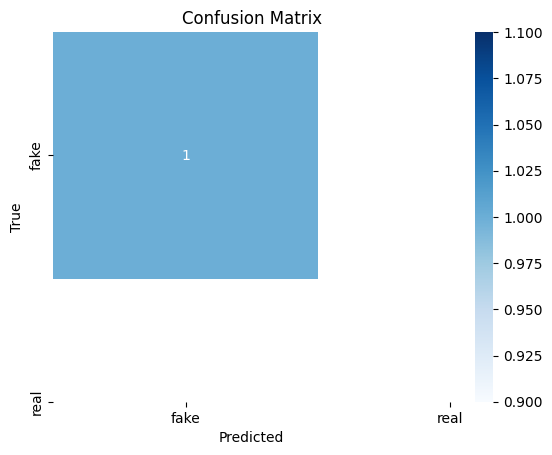

In [30]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [31]:
df["predicted_label"] = clf.predict(df[features])
df.to_csv("data/data_processed/final_predictions.csv", index=False)
print("Final predictions saved to data/data_processed/final_predictions.csv")


Final predictions saved to data/data_processed/final_predictions.csv
